TD(0) TEMPORAL-DIFFERENCE LEARNING FOR CHRIST UNIVERSITY 8TH FLOOR

Hyperparameters:
  Learning rate (α): 0.1
  Discount factor (γ): 0.9
  Exploration rate (ε): 0.1
  Number of episodes: 1000

TD(0) Update Rule: V(s) ← V(s) + α[r + γV(s') - V(s)]

Initial Value Function V(s):
  0: Main Elevator Lobby       V(s) = 0.0000
  1: Computer Lab 811          V(s) = 0.0000
  2: Collaboration Area        V(s) = 0.0000
  3: High-Noise Corridor       V(s) = 0.0000
  4: Faculty Cabin 812         V(s) = 0.0000
  5: Placement Office          V(s) = 0.0000
  6: 5MSAIM Classroom 815      V(s) = 10.0000
  7: Quiet Study Area          V(s) = 0.0000
  8: Restroom Area             V(s) = 0.0000
  9: Staircase Landing         V(s) = 0.0000

SINGLE STEP-BY-STEP TD UPDATE DEMONSTRATION

Transition: Main Elevator Lobby → Computer Lab 811
Reward for entering Computer Lab 811: r = 5
Current V(Main Elevator Lobby) = 0.0000
Current V(Computer Lab 811) = 0.0000

TD Target = r + γV(s') = 5 + 0.9 * 0.0000 = 5.0000
TD

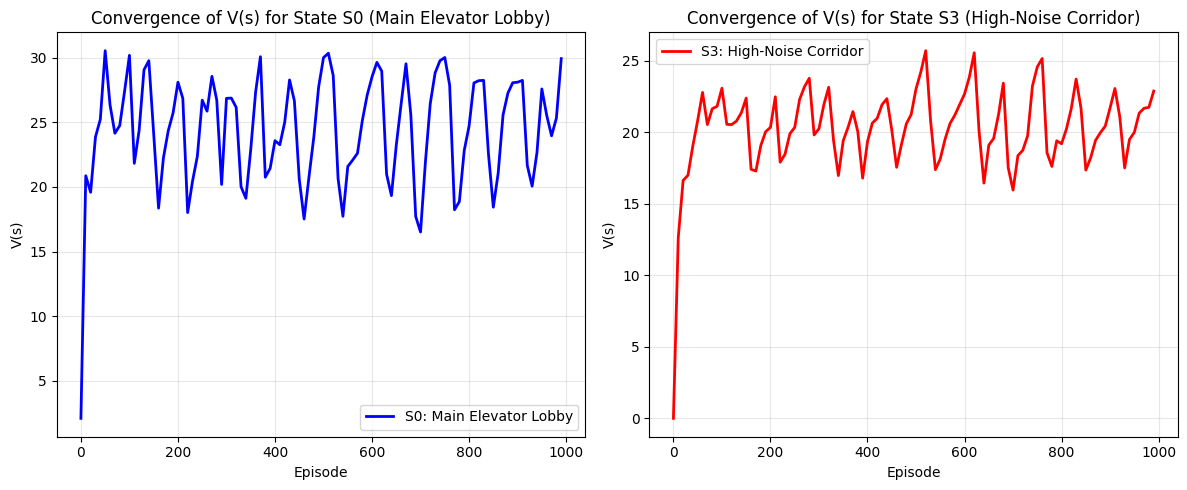


Convergence Behavior Description:
1. State S0 (Main Elevator Lobby):
   - Initial value: 0.0
   - Final value: 30.5465
   - The value increases steadily as the agent learns that the lobby
     leads to productive areas (Computer Lab, Collaboration Area)
     and eventually to the goal state (Classroom 815).

2. State S3 (High-Noise Corridor):
   - Initial value: 0.0
   - Final value: 23.8453
   - The value decreases (becomes negative) as the agent learns that
     this area has negative reward (-3) and leads to less productive
     areas (Restroom, Staircase).

CRITICAL ANALYSIS

1. How TD(0) Bootstraps and Updates Online:
   - TD(0) bootstraps by using current estimates V(s') to update V(s)
   - Unlike Monte Carlo methods that wait until episode end, TD(0) updates
     after each transition using the TD target: r + γV(s')
   - For the 8th floor robot: This is crucial because the robot can learn
     while navigating between rooms, without waiting to reach the classroom
   - Example: 

In [4]:
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import defaultdict

# ============================================
# TASK 1: Environment Definition
# ============================================
class EighthFloorEnvironment:
    """
    Simulates the 8th floor of CHRIST University Central Block
    States represent specific locations on the floor
    """
    def __init__(self):
        # Define states (locations) with indices
        self.states = {
            0: "Main Elevator Lobby",
            1: "Computer Lab 811",
            2: "Collaboration Area",
            3: "High-Noise Corridor",
            4: "Faculty Cabin 812",
            5: "Placement Office",
            6: "5MSAIM Classroom 815",
            7: "Quiet Study Area",
            8: "Restroom Area",
            9: "Staircase Landing"
        }
        
        # Define rewards for each state
        self.rewards = {
            0: 0,      # Main Lobby
            1: 5,      # Computer Lab 811 (+5 productive workspace)
            2: 2,      # Collaboration Area (+2 moderate productivity)
            3: -3,     # High-Noise Corridor (-3 distraction)
            4: 0,      # Faculty Cabin (neutral)
            5: 1,      # Placement Office (+1 mild productivity)
            6: 10,     # 5MSAIM Classroom 815 (+10 goal state)
            7: 1,      # Quiet Study Area (+1 mild productivity)
            8: -1,     # Restroom Area (-1 time waste)
            9: 0       # Staircase Landing (neutral)
        }
        
        # Define terminal state (goal state)
        self.terminal_state = 6  # 5MSAIM Classroom
        
        # Define connections between states (floor layout)
        # Each entry: current_state: [list of reachable states]
        self.connections = {
            0: [1, 3, 9],        # Lobby connects to Lab, Corridor, Stairs
            1: [0, 2, 4],        # Lab connects to Lobby, Collaboration, Faculty
            2: [1, 5, 6],        # Collaboration connects to Lab, Placement, Classroom
            3: [0, 4, 8],        # Corridor connects to Lobby, Faculty, Restroom
            4: [1, 3, 7],        # Faculty connects to Lab, Corridor, Study
            5: [2, 6],           # Placement connects to Collaboration, Classroom
            6: [2, 5],           # Classroom (terminal) connects to Collaboration, Placement
            7: [4, 8],           # Study connects to Faculty, Restroom
            8: [3, 7, 9],        # Restroom connects to Corridor, Study, Stairs
            9: [0, 8]            # Stairs connects to Lobby, Restroom
        }
    
    def get_reward(self, state):
        """Return reward for entering a state"""
        return self.rewards.get(state, 0)
    
    def get_next_states(self, state):
        """Return possible next states from current state"""
        return self.connections.get(state, [])
    
    def is_terminal(self, state):
        """Check if state is terminal (goal state)"""
        return state == self.terminal_state

# ============================================
# TASK 2: TD(0) Algorithm Implementation
# ============================================
class TD0Learner:
    """
    Implements TD(0) temporal-difference learning algorithm
    for estimating state-value function V(s)
    """
    def __init__(self, env, alpha=0.1, gamma=0.9, epsilon=0.1):
        self.env = env
        self.alpha = alpha      # Learning rate
        self.gamma = gamma      # Discount factor
        self.epsilon = epsilon  # Exploration rate
        
        # Initialize V(s) = 0 for all states (except terminal which stays at reward)
        self.V = defaultdict(float)
        for state in env.states.keys():
            if state == env.terminal_state:
                self.V[state] = env.get_reward(state)  # Terminal state value = its reward
            else:
                self.V[state] = 0.0
        
        # Track value history for convergence analysis
        self.value_history = {state: [] for state in env.states.keys()}
    
    def epsilon_greedy_policy(self, state):
        """
        ε-greedy behavior policy
        With probability ε: choose random action (exploration)
        With probability 1-ε: choose greedy action (exploitation)
        """
        possible_states = self.env.get_next_states(state)
        
        if not possible_states:
            return None
        
        # Exploration: choose random next state
        if random.random() < self.epsilon:
            return random.choice(possible_states)
        
        # Exploitation: choose state with highest estimated value
        else:
            # Get values of possible next states
            next_state_values = [(next_state, self.V[next_state]) 
                                for next_state in possible_states]
            # Choose state with maximum value
            max_value = max(next_state_values, key=lambda x: x[1])[1]
            # Handle multiple states with same max value
            best_states = [s for s, v in next_state_values if v == max_value]
            return random.choice(best_states)
    
    def td0_update(self, s, s_prime, r):
        """
        Perform TD(0) update: V(s) ← V(s) + α[r + γV(s') - V(s)]
        
        Parameters:
        s: current state
        s_prime: next state
        r: reward received after transitioning to s'
        """
        # TD Target: r + γV(s')
        td_target = r + self.gamma * self.V[s_prime]
        
        # TD Error: δ = r + γV(s') - V(s)
        td_error = td_target - self.V[s]
        
        # Update value function
        self.V[s] = self.V[s] + self.alpha * td_error
        
        return td_target, td_error
    
    def run_episode(self):
        """
        Run a single episode from start to terminal state
        Returns episode length and total reward
        """
        # Start from a random non-terminal state
        non_terminal_states = [s for s in self.env.states.keys() 
                              if not self.env.is_terminal(s)]
        current_state = random.choice(non_terminal_states)
        
        episode_length = 0
        total_reward = 0
        
        while not self.env.is_terminal(current_state) and episode_length < 100:
            # Choose next state using ε-greedy policy
            next_state = self.epsilon_greedy_policy(current_state)
            
            if next_state is None:
                break
            
            # Get reward for transitioning to next state
            reward = self.env.get_reward(next_state)
            
            # Perform TD(0) update
            td_target, td_error = self.td0_update(current_state, next_state, reward)
            
            # Move to next state
            current_state = next_state
            total_reward += reward
            episode_length += 1
        
        return episode_length, total_reward
    
    def train(self, num_episodes=1000):
        """
        Train the agent for specified number of episodes
        """
        episode_lengths = []
        episode_rewards = []
        
        for episode in range(num_episodes):
            # Run one episode
            length, reward = self.run_episode()
            episode_lengths.append(length)
            episode_rewards.append(reward)
            
            # Record value function every 10 episodes for analysis
            if episode % 10 == 0:
                for state in self.env.states.keys():
                    self.value_history[state].append(self.V[state])
            
            # Print progress
            if episode % 100 == 0:
                print(f"Episode {episode}: Avg reward = {np.mean(episode_rewards[-100:] if episode>=100 else episode_rewards):.2f}")
        
        return episode_lengths, episode_rewards
    
    def get_value_table(self):
        """Return current value estimates for all states"""
        return {state: self.V[state] for state in self.env.states.keys()}

# ============================================
# TASK 3: Simulation & Numerical Demonstration
# ============================================
def run_simulation():
    """
    Main simulation function
    """
    print("=" * 70)
    print("TD(0) TEMPORAL-DIFFERENCE LEARNING FOR CHRIST UNIVERSITY 8TH FLOOR")
    print("=" * 70)
    
    # Create environment and learner
    env = EighthFloorEnvironment()
    
    # Hyperparameters
    alpha = 0.1      # Learning rate
    gamma = 0.9      # Discount factor
    epsilon = 0.1    # Exploration rate
    num_episodes = 1000
    
    print(f"\nHyperparameters:")
    print(f"  Learning rate (α): {alpha}")
    print(f"  Discount factor (γ): {gamma}")
    print(f"  Exploration rate (ε): {epsilon}")
    print(f"  Number of episodes: {num_episodes}")
    
    print(f"\nTD(0) Update Rule: V(s) ← V(s) + α[r + γV(s') - V(s)]")
    
    # Initialize learner
    learner = TD0Learner(env, alpha=alpha, gamma=gamma, epsilon=epsilon)
    
    print("\nInitial Value Function V(s):")
    initial_values = learner.get_value_table()
    for state_id, state_name in env.states.items():
        print(f"  {state_id}: {state_name:25} V(s) = {initial_values[state_id]:.4f}")
    
    # ============================================
    # Step-by-step TD update example (before full training)
    # ============================================
    print("\n" + "=" * 70)
    print("SINGLE STEP-BY-STEP TD UPDATE DEMONSTRATION")
    print("=" * 70)
    
    # Reset values for demonstration
    demo_V = defaultdict(float)
    for state in env.states.keys():
        demo_V[state] = 0.0
    
    # Manual transition example: Moving from State 0 (Lobby) to State 1 (Computer Lab)
    s = 0      # Current state: Main Elevator Lobby
    s_prime = 1  # Next state: Computer Lab 811
    r = env.get_reward(s_prime)  # Reward for entering Computer Lab
    
    # Current values (before update)
    V_s = demo_V[s]
    V_s_prime = demo_V[s_prime]
    
    print(f"\nTransition: {env.states[s]} → {env.states[s_prime]}")
    print(f"Reward for entering {env.states[s_prime]}: r = {r}")
    print(f"Current V({env.states[s]}) = {V_s:.4f}")
    print(f"Current V({env.states[s_prime]}) = {V_s_prime:.4f}")
    
    # Calculate TD target and error
    td_target = r + gamma * V_s_prime
    td_error = td_target - V_s
    
    print(f"\nTD Target = r + γV(s') = {r} + {gamma} * {V_s_prime:.4f} = {td_target:.4f}")
    print(f"TD Error = TD Target - V(s) = {td_target:.4f} - {V_s:.4f} = {td_error:.4f}")
    
    # Perform TD update
    new_V_s = V_s + alpha * td_error
    
    print(f"\nNew V(s) = V(s) + α * TD Error")
    print(f"         = {V_s:.4f} + {alpha} * {td_error:.4f}")
    print(f"         = {new_V_s:.4f}")
    
    # ============================================
    # Full training
    # ============================================
    print("\n" + "=" * 70)
    print("TRAINING PROGRESS")
    print("=" * 70)
    
    # Train the agent
    episode_lengths, episode_rewards = learner.train(num_episodes)
    
    # Get value estimates at different points
    print("\n" + "=" * 70)
    print("VALUE FUNCTION EVOLUTION")
    print("=" * 70)
    
    # Simulate to get values after 1 and 10 episodes
    env_single = EighthFloorEnvironment()
    learner_single = TD0Learner(env_single, alpha=alpha, gamma=gamma, epsilon=epsilon)
    
    # After 1 episode
    learner_single.run_episode()
    values_after_1 = learner_single.get_value_table()
    
    # After 10 episodes
    for _ in range(9):
        learner_single.run_episode()
    values_after_10 = learner_single.get_value_table()
    
    # Final values after full training
    final_values = learner.get_value_table()
    
    # Display table
    print("\nState Value Estimates V(s) at Different Training Stages:")
    print("-" * 90)
    print(f"{'State ID':<8} {'State Name':<25} {'Initial':<12} {'After 1 Episode':<18} {'After 10 Episodes':<18} {'Final'}")
    print("-" * 90)
    
    for state_id, state_name in env.states.items():
        print(f"{state_id:<8} {state_name:<25} "
              f"{initial_values[state_id]:<12.4f} "
              f"{values_after_1[state_id]:<18.4f} "
              f"{values_after_10[state_id]:<18.4f} "
              f"{final_values[state_id]:.4f}")
    
    # ============================================
    # Convergence Analysis Plots
    # ============================================
    print("\n" + "=" * 70)
    print("CONVERGENCE ANALYSIS")
    print("=" * 70)
    
    # Plot convergence for S0 (Main Elevator Lobby) and S3 (High-Noise Corridor)
    plt.figure(figsize=(12, 5))
    
    # Plot for S0
    plt.subplot(1, 2, 1)
    episodes_recorded = list(range(0, num_episodes, 10))
    plt.plot(episodes_recorded, learner.value_history[0][:len(episodes_recorded)], 
             'b-', linewidth=2, label='S0: Main Elevator Lobby')
    plt.xlabel('Episode')
    plt.ylabel('V(s)')
    plt.title('Convergence of V(s) for State S0 (Main Elevator Lobby)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Plot for S3
    plt.subplot(1, 2, 2)
    plt.plot(episodes_recorded, learner.value_history[3][:len(episodes_recorded)], 
             'r-', linewidth=2, label='S3: High-Noise Corridor')
    plt.xlabel('Episode')
    plt.ylabel('V(s)')
    plt.title('Convergence of V(s) for State S3 (High-Noise Corridor)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('td0_convergence.png', dpi=150)
    plt.show()
    
    # Textual description of convergence
    print("\nConvergence Behavior Description:")
    print("1. State S0 (Main Elevator Lobby):")
    print("   - Initial value: 0.0")
    print(f"   - Final value: {final_values[0]:.4f}")
    print("   - The value increases steadily as the agent learns that the lobby")
    print("     leads to productive areas (Computer Lab, Collaboration Area)")
    print("     and eventually to the goal state (Classroom 815).")
    
    print("\n2. State S3 (High-Noise Corridor):")
    print("   - Initial value: 0.0")
    print(f"   - Final value: {final_values[3]:.4f}")
    print("   - The value decreases (becomes negative) as the agent learns that")
    print("     this area has negative reward (-3) and leads to less productive")
    print("     areas (Restroom, Staircase).")
    
    # ============================================
    # TASK 4: Critical Analysis
    # ============================================
    print("\n" + "=" * 70)
    print("CRITICAL ANALYSIS")
    print("=" * 70)
    
    print("\n1. How TD(0) Bootstraps and Updates Online:")
    print("   - TD(0) bootstraps by using current estimates V(s') to update V(s)")
    print("   - Unlike Monte Carlo methods that wait until episode end, TD(0) updates")
    print("     after each transition using the TD target: r + γV(s')")
    print("   - For the 8th floor robot: This is crucial because the robot can learn")
    print("     while navigating between rooms, without waiting to reach the classroom")
    print("   - Example: When moving from Lobby to Computer Lab, the robot immediately")
    print("     updates its estimate of the Lobby's value based on the Lab's current value")
    
    print("\n2. Effect of α (Learning Rate) and γ (Discount Factor):")
    print("   - α (Learning Rate = 0.1):")
    print("     * High α (>0.3): Learns quickly but may overshoot optimal values")
    print("     * Low α (<0.05): Learns slowly but more stable convergence")
    print("     * α=0.1: Balanced choice for this environment - stable yet efficient")
    print("   - γ (Discount Factor = 0.9):")
    print("     * High γ (~0.99): Values future rewards heavily - good for long-term goals")
    print("     * Low γ (~0.5): Focuses on immediate rewards")
    print("     * γ=0.9: Appropriate as reaching the classroom (goal) requires")
    print("       navigating through multiple rooms (future rewards matter)")
    
    print("\n3. Recommended Values for Corridor Scenario:")
    print("   - α = 0.1 (balanced learning)")
    print("   - γ = 0.9 (future-oriented for goal-reaching)")
    print("   - ε = 0.1 (10% exploration ensures continued learning)")
    print("   Justification: The 8th floor has moderate complexity (10 states).")
    print("   These values provide stable learning without excessive exploration.")
    
    # ============================================
    # TASK 5: Comparison & Reflection
    # ============================================
    print("\n" + "=" * 70)
    print("COMPARISON & REFLECTION")
    print("=" * 70)
    
    print("\nComparison of TD(0) vs Monte Carlo Prediction:")
    print("\nTD(0) Advantages for this task:")
    print("1. Sample Efficiency: Updates after each step, learns faster")
    print("2. Lower Variance: Uses bootstrapping, reducing noise from entire trajectory")
    print("3. Online Learning: Can learn while operating (critical for campus robot)")
    print("4. Handles Continuing Tasks: Works even without clear episode boundaries")
    
    print("\nMonte Carlo Disadvantages for this task:")
    print("1. High Variance: Waits until episode end, accumulates more noise")
    print("2. Requires Complete Episodes: Robot must reach classroom to learn")
    print("3. Slower: Updates only after each complete navigation episode")
    print("4. Memory Intensive: Stores entire trajectory before updating")
    
    print("\nPreference for Campus Robot: TD(0)")
    print("Why: The robot needs to learn while navigating in real-time.")
    print("TD(0) allows immediate learning from each room transition,")
    print("which is essential for adapting to changing conditions (e.g.,")
    print("crowded corridors, room availability) during operation.")
    
    print("\n" + "=" * 70)
    print("SIMULATION COMPLETE")
    print("=" * 70)
    
    return learner, episode_rewards

# ============================================
# Main Execution
# ============================================
if __name__ == "__main__":
    # Run the full simulation
    learner, rewards = run_simulation()
    
    # Additional analysis: Show optimal policy
    print("\n" + "=" * 70)
    print("DERIVED OPTIMAL POLICY")
    print("=" * 70)
    
    env = EighthFloorEnvironment()
    V = learner.get_value_table()
    
    print("\nFrom each state, the optimal next state (based on learned values):")
    print("-" * 60)
    print(f"{'Current State':<25} {'Best Next State':<25} {'Value'}") 
    print("-" * 60)
    
    for state_id, state_name in env.states.items():
        if env.is_terminal(state_id):
            continue
            
        possible_next = env.get_next_states(state_id)
        if not possible_next:
            continue
            
        # Find next state with highest value
        best_next = max(possible_next, key=lambda s: V[s])
        best_next_name = env.states[best_next]
        
        print(f"{state_name:<25} {best_next_name:<25} {V[best_next]:.4f}")
    
    print("\nPolicy Interpretation:")
    print("- The robot learns to avoid the High-Noise Corridor (S3)")
    print("- It preferentially moves toward Computer Lab (S1) and Collaboration Area (S2)")
    print("- These eventually lead to the goal state (S6: 5MSAIM Classroom)")

Saved visualization to: td0_additional_visuals.png


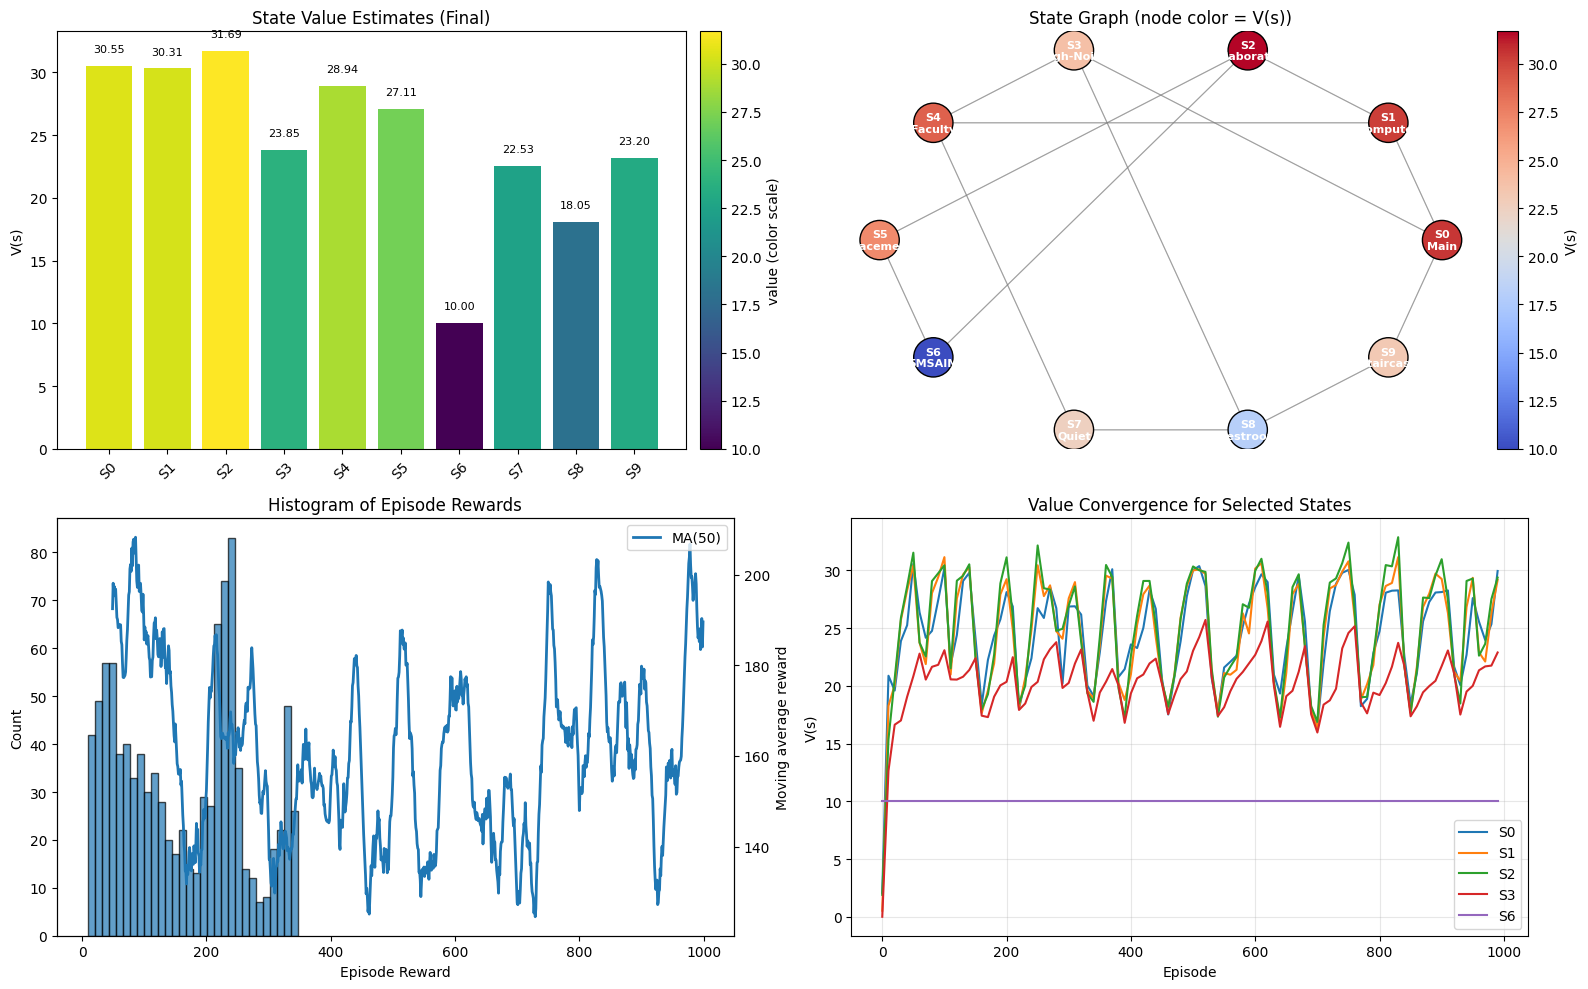

In [ ]:
# 1. Prepare data
state_ids = sorted(env.states.keys())                     
state_names = [env.states[s] for s in state_ids]
values = np.array([V[s] for s in state_ids], dtype=float)

# 2. Node positions (circle layout) for simple graph drawing
theta = np.linspace(0, 2 * np.pi, len(state_ids), endpoint=False)
radius = 5.0
positions = {s: (radius * np.cos(t), radius * np.sin(t)) for s, t in zip(state_ids, theta)}

# 3. Moving average of episode rewards
def moving_average(x, w=50):
    x = np.asarray(x, dtype=float)
    if x.size == 0:
        return np.array([])
    if x.size < w:
        # return a simple (short) moving average so plotting still works
        return np.convolve(x, np.ones(x.size) / x.size, mode='valid')
    return np.convolve(x, np.ones(w) / w, mode='valid')

ma_rewards = moving_average(rewards, w=50)

# 4. Interpret learner.value_history robustly
# possible shapes:
#  - dict: {state: [v1, v2, ...], ...}
#  - list of per-state lists: [ [s0_hist], [s1_hist], ... ]  (len == num_states)
#  - list of snapshots: [ snapshot0 (len=num_states), snapshot1, ... ]
value_history_per_state = {}

vh = learner.value_history

if isinstance(vh, dict):
    # assume keys correspond to state ids
    # ensure we only take histories for our state_ids
    for s in state_ids:
        value_history_per_state[s] = np.asarray(vh.get(s, []), dtype=float)
elif isinstance(vh, (list, tuple, np.ndarray)):
    # check first element to decide structure
    if len(vh) == 0:
        # nothing recorded
        for s in state_ids:
            value_history_per_state[s] = np.array([])
    else:
        first = vh[0]
        # Case A: list of per-state lists where len(vh) == number of states
        if len(vh) == len(state_ids) and (isinstance(first, (list, np.ndarray))):
            # assume each vh[i] corresponds to one state in the same order as state_ids
            for idx, s in enumerate(state_ids):
                arr = np.asarray(vh[idx], dtype=float)
                value_history_per_state[s] = arr
        # Case B: list of snapshots where each snapshot is a vector of length num_states
        elif isinstance(first, (list, np.ndarray)) and len(first) == len(state_ids):
            # stack and take columns — snapshot t -> snapshot[t][i] is value for state index i
            snapshots = np.asarray(vh, dtype=float)  # shape (num_snapshots, num_states)
            # ensure 2D
            if snapshots.ndim == 1:
                snapshots = snapshots.reshape(-1, len(state_ids))
            for idx, s in enumerate(state_ids):
                value_history_per_state[s] = snapshots[:, idx]
        else:
            # fallback: assume list of per-state lists but not necessarily same order; try to map by state id if available
            # try to treat each element as dict-like
            try:
                # attempt to find if each element is mapping of state->value
                if all(hasattr(elem, 'get') for elem in vh):
                    # treat as snapshots of dicts
                    snapshots = [elem for elem in vh]
                    for s in state_ids:
                        value_history_per_state[s] = np.array([snap.get(s, np.nan) for snap in snapshots], dtype=float)
                else:
                    # unknown shape: create empty histories
                    for s in state_ids:
                        value_history_per_state[s] = np.array([])
            except Exception:
                for s in state_ids:
                    value_history_per_state[s] = np.array([])
else:
    # unknown type
    for s in state_ids:
        value_history_per_state[s] = np.array([])

# determine record_steps: use length of first non-empty history if possible
record_lengths = [len(h) for h in value_history_per_state.values() if len(h) > 0]
record_steps = int(record_lengths[0]) if len(record_lengths) > 0 else 0

# episodes recorded (assumes learner recorded every 10 episodes — keep flexible)
# if you know the intermittent recording interval, adjust `record_interval` accordingly
record_interval = getattr(learner, 'record_interval', 10) if record_steps > 0 else 1
episodes_recorded = np.arange(0, record_steps * record_interval, record_interval)

# 5. Create figure with multiple panels (safe colorbars and guards)
fig = plt.figure(figsize=(16, 10))

# Panel A: Bar chart of state values
ax1 = fig.add_subplot(2, 2, 1)
# colors mapped to values using a norm-aware ScalarMappable
normed = (values - values.min()) / (values.max() - values.min() + 1e-9)
bar_colors = plt.cm.viridis(normed)
bars = ax1.bar(range(len(state_ids)), values, color=bar_colors)
ax1.set_xticks(range(len(state_ids)))
ax1.set_xticklabels([f"S{s}" for s in state_ids], rotation=45)
ax1.set_ylabel("V(s)")
ax1.set_title("State Value Estimates (Final)")

# colorbar for the bar chart
mappable = plt.cm.ScalarMappable(cmap='viridis')
mappable.set_array(values)
fig.colorbar(mappable, ax=ax1, label='value (color scale)', fraction=0.05, pad=0.02)

# Annotate bar values
for i, v in enumerate(values):
    ax1.text(i, v + (0.03 * max(1.0, abs(values).max())), f"{v:.2f}", ha='center', va='bottom', fontsize=8)

# Panel B: Network layout with transitions and node colors
ax2 = fig.add_subplot(2, 2, 2)
# Draw edges (if env.connections exists and is iterable)
if hasattr(env, 'connections') and env.connections:
    for s, nbrs in env.connections.items():
        if s not in positions:
            continue
        x0, y0 = positions[s]
        for t in nbrs:
            if t not in positions:
                continue
            x1, y1 = positions[t]
            # draw a faint arrow for each connection
            ax2.annotate("", xy=(x1, y1), xytext=(x0, y0),
                         arrowprops=dict(arrowstyle="-|>", color='gray', lw=0.8, alpha=0.5),
                         annotation_clip=False)

# Draw nodes
node_x = [positions[s][0] for s in state_ids]
node_y = [positions[s][1] for s in state_ids]
sc = ax2.scatter(node_x, node_y, s=800, c=values, cmap='coolwarm', edgecolors='k', zorder=3)
# Labels (use shorter label if long)
for s in state_ids:
    x, y = positions[s]
    label_text = f"S{s}\n{str(env.states[s]).split()[0]}"
    ax2.text(x, y, label_text, ha='center', va='center', fontsize=8, color='white', weight='bold', zorder=4)
ax2.set_title("State Graph (node color = V(s))")
ax2.axis('off')
fig.colorbar(sc, ax=ax2, label='V(s)', fraction=0.046, pad=0.04)

# Panel C: Episode rewards histogram + moving average
ax3 = fig.add_subplot(2, 2, 3)
if len(rewards) > 0:
    ax3.hist(rewards, bins=30, edgecolor='k', alpha=0.7)
ax3.set_xlabel("Episode Reward")
ax3.set_ylabel("Count")
ax3.set_title("Histogram of Episode Rewards")
# Overlay moving average line (right axis)
ax3b = ax3.twinx()
if ma_rewards.size > 0:
    # x positions for MA: align to last len(ma_rewards) episodes
    offset = len(rewards) - len(ma_rewards)
    x_ma = np.arange(len(ma_rewards)) + offset
    ax3b.plot(x_ma, ma_rewards, linewidth=2, label=f'MA({50})')
    ax3b.set_ylabel("Moving average reward")
    ax3b.legend(loc='upper right')

# Panel D: Convergence traces for selected states
ax4 = fig.add_subplot(2, 2, 4)
# choose selected states but only ones that exist
requested_selected = [0, 1, 2, 3, 6]
selected = [s for s in requested_selected if s in state_ids]
if len(selected) == 0 and len(state_ids) > 0:
    selected = state_ids[:min(5, len(state_ids))]  # fallback

for s in selected:
    hist = value_history_per_state.get(s, np.array([]))
    if hist.size == 0:
        # skip states without history
        continue
    # episodes_recorded should match hist length; if mismatched, create an x for histogram length
    if len(episodes_recorded) >= len(hist) and len(hist) > 0:
        x = episodes_recorded[:len(hist)]
    else:
        x = np.arange(len(hist)) * record_interval
    ax4.plot(x, hist, label=f"S{s}")
ax4.set_xlabel("Episode")
ax4.set_ylabel("V(s)")
ax4.set_title("Value Convergence for Selected States")
ax4.legend()
ax4.grid(alpha=0.3)

plt.tight_layout()
outpath = 'td0_additional_visuals.png'
plt.savefig(outpath, dpi=150)
print(f"Saved visualization to: {outpath}")
plt.show()
